In [ ]:
%load_ext autoreload
%autoreload 2
from notebook import *
# if get something about NUMEXPR_MAX_THREADS being set incorrectly, don't worry.  It's not a problem.

<div class="namebox">    
Double Click to edit and enter your

1.  Name
2.  Student ID
3.  @ucsd.edu email address
    
</div>

<div style=" font-size: 300% !important;
    margin-top: 1.5em;
    margin-bottom: 10px;
    font-weight: bold;
    line-height: 1.0;
    text-align:center;">
Programming Assignment 3: Optimizing Markov Chains with Cache-Aware Optimizations!
</div>

In this programming assignment, you'll practice how to parallelize a program using OpenMP. You should get roughly $1.5\times$  more speedup compared with the last programming assignment (i.e., $24\times$ on Gradescope after your parallelization). 

Check the course schedule for due date(s).

# How to succeed in programming assignments

## Browser Compatibility

We are still working out some bugs in some browsers.  Here's the current status:

1.  Chrome -- well tested.  Preferred option.
2.  Firefox -- seems ok, but not thoroughly tested.
3.  Edge -- seems ok, but not thoroughly tested.
4.  Safari -- not supported at the moment.
5.  Internet Explorer -- not supported at the moment.

At the moment, the authentication step must be done in Chrome.

## Keeping Your assignment/lab Up-to-Date

Occasionally, there will be changes made to the base repository after the
lab is released.  This may include bug fixes and updates to this document.  We'll post on piazza/edstem when an update is available.

In those cases, you can use the following commands to pull the changes from upstream and merge them into your code.  You'll need to do this at a shell.  It won't work properly in the notebook.  Save your notebook in the browser first.


```
cd <your directory for this assignment/lab>git remote add upstream $(cat .starter_repo)  # You need to do this once each time you checkout a new assignment/lab. It will fail 
                                              # harmlessly if you run it more than once.
cp assignment-lab.ipynb assignment-lab.backup.ipynb                 # Backup your work.
git commit -am "My progress so far."          # commit your work.
git pull upstream main --allow-unrelated-histories -X theirs # pull the updates
```

Or you can use the script we provide:

In [ ]:
# Be sure to click save to preseve your progress before updating
! ./fix-repo
! ./pull-updates

Then, reload this page in your browser.

## How To Use This Document

You will use Jupyter Notebook to complete this assignment/lab.  You should be able to do much of this assignment/lab without leaving Jupyter Notebook.  The main exception will be some of the programming chanllenges.  The instructions will make it clear when you should use the terminal.

### Running Code

Jupyter Notebooks are made up of "cells".  Some have Markdown-formatted text in them (like this one).  Some have Python code (like the one below).

For code cells, you press `shift-return` to execute the code.  Try it below:

In [ ]:
print("I'm in python")

Code cells can also execute shell commands using the `!` operator.  Try it below:

In [ ]:
!echo "I'm in a shell"

### Telling What The Notebook is Doing

The notebook will only run one cell at a time, so if you press `shift-return` several times, the cells will wait for one another.  You can tell that a cell is waiting if it there's a `*` in the `[]` to the left the cell:

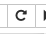


You'll can also tell _where_ the notebook is executing by looking at the table of contents on the left.  The section with the currently-executing cell will be red:

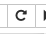

### What to Do Jupyter Notebook It Gets Stuck

First, check if it's actually stuck: Some of the cells take a while, but they will usually provide some visual sign of progress.  If _nothing_ is happening for more than 10 seconds, it's probably stuck.

To get it unstuck, you stop execution of the current cell with the "interrupt button":

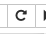

You can also restart the underlying python instance (i.e., the confusingly-named "kernel" which is not the same thing as the operating system kernel) with the restart button:

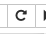

Once you do this, all the variables defined by earlier cells are gone, so you may get some errors.  You may need to re-run the cells in the current section to get things to work again.

You can also try reloading the web page.  That will leave Python kernel intact, but it can help with some problems.

### Use VSCode

The container that we build for CSE142L provides a more friendly "VSCode" environment. To launch that environment, you should find and press the `+` icon near the file menu.

![plus.png](plus.png)

The interface will move to a launcher where you may find the following VSCode icon.

![vscode.png](vscode.png)

Press that icon and then you can enjoy VSCode environment!

# OpenMP (New For Programming Assignment 3)

OpenMP is automatically turned for your code in this assignment, so the `#pragma` command we used for the histogram should work fine.

If you want to compile at the command line, you'll need to either do 

```
export OPENMP=yes
```

once each time you log in or invoke `make` like so:

```
make join.exe OPENMP=yes
```
each time you build.

## Key Commands

The three `#pragma`s you'll need for this assignment are 

1. `#pragma omp parallel for` for parallelizing loops.
2. `#pragma omp critical` for parallelizing loops.
3. `#pragma omp simd` for vectorizing loops

These are the only three used in the solution used to set the performance targets.

These three blog posts provide a good introduction to these commands:

* http://jakascorner.com/blog/2016/04/omp-introduction.html  
* http://jakascorner.com/blog/2016/05/omp-for.html
* http://jakascorner.com/blog/2016/07/omp-critical.html

They are required reading.

These articles provide some more advanced topics that might be useful:

* http://jakascorner.com/blog/2016/06/omp-for-scheduling.html
* http://jakascorner.com/blog/2016/06/omp-data-sharing-attributes.html
* http://jakascorner.com/blog/2016/07/omp-default-none-and-const.html

There's an enormous amount of bad information online about OpenMP.

## Looking at OpenMP Assembly

If you look at the assembly for OpenMP programs, you'll find that your loop body has been replaced with a function call.  OpenMP does this so it can tell it's worker threads to call the function to perform one iteration of your loop.

## Caveats for our Tools

First, `gprof` doesn't work on with multi-threaded programs.  You can use it for single-threaded runs, though.

Second, Moneta's cache model is not multithread-aware, so the cache hit/miss numbers for multithreaded programs are not meaningful.

Moneta may also show more threads that you might be expecting.  OpenMP threads seem to be Thread 0 and 13 and above.  If you see some threads that don't seem to be doing anything, that's not surprising or concerning.

Finally, our performance counting code only collects data for one thread.  For OpenMP code this is ok:  all the threads do basically the same thing.  But you'll notice, for instance, that if a loop runs in 4 threads, the measure instruction count will go down by ~1/4 (assuming multi-threading didn't add a lot of overhead).
 
 
## Controlling the Number of Threads

By default the autograder will run your code with 12 threads.  If you want to use a different number in your final run, you can call 

```			
omp_set_num_threads(thread_count);
```

in your function. You should call it before the first OpenMP `#pragma`.

I can control thread count during development with `-t`.  


# Markov Chain

For your programming assignment in this assignment, we will use "markov chain" to practice cache-aware performance optimizations. 

Markov chain is a very useful tool to predict the trend of a target object using a transition matrix $T$ created from historical data. Each element $T_{i,j}$ in the transition matrix represents the probability of the next state of the target object is $j$ if the object's current state is $i$. 

Let's use a student's grade as an example and use A, B, C to represent the state of a student's grade. Based on the histrocial data, if the student currently obtains an A, the probablity that the student will get an A is 0.7, B is 0.2, and C is 0.1 for the upcoming assignment. If the  student currently obtains an B, the probablity that the student will get an A is 0.4, B is 0.4, and C is 0.2. If the student currently obtains an C, the probablity that the student will get an A is 0.2, B is 0.4, and C is 0.4. 

The above statistics can be expressed as the following markov chain transition matrix $T$. 
$$
\begin{bmatrix}
0.7 & 0.4 & 0.2\\
0.2 & 0.4 & 0.4\\
0.1 & 0.2 & 0.4
\end{bmatrix}
$$
In the matrix, we assume column 0 represents the transition probablities from A to A, B, C in the next assignment, column 1 represents the transition probablities from B to A, B, C in the next assignment, and column 2 represents the transition probablities from A to A, B, C in the next assignment.

If the student current obtain an A, we can express the student's current state as a vector $S$ as below, 
$$
\begin{bmatrix}
1 & 0 & 0\\
\end{bmatrix}
$$
, since the 0th column represents the state as A.

To project the grade of the student's next assigment, we can perform $S_{2} = S \times T $, and $S_{2}$ will contain the probability of the student's next assignment. To get a projection of the student's $i$th assignment, you should repeatedly perform $S_{i} = S_{i-1} \times T $

# The baseline program

In this programming assignment, we provide a poorly optimized baseline. It accepts arguments on the number of states and the number of "days" the state should evolve. It randomly generates a transition matrix and pick state to start. The program will invoke `markov_reference` or `markov_solution` (your optimized implementation) to get the projection after the desired number of days.

## Reference Code

The reference implementation of `markov_reference` is in `markov_reference.hpp`:

In [ ]:
render_code("markov_reference.hpp")

The baseline code performs a vector-matrix multiplication in the inner two loops and iterates the inner loops with number of days.

You're supposed to write your optimized version and only allowed to modify code in `markov_solution.hpp`:

In [ ]:
render_code("markov_solution.hpp")

Read through the code and comments to make sure you understand what the code is doing. The given version of `markov_solution` is currently identical to the 

## Detailed Requirements

The requirements for the assignment are pretty simple:

1. Values in ``scale`` and ``days`` can be any `uint64_t` value.
2. Your output must match the output of the code in `markov_reference.hpp`.
3. Your implementation should go in `markov_solution.hpp`.  The starter version is just a copy of `markov_reference.hpp`.
4. Your implementation must generate exact the same result as `markov_reference` function.
5. Your implementation must achieve at least 24 $\times$ speedup on gradescope to score (roughly 28 $\times$ speedup in the cluster). The performance number you got in the datahub cluster does not count toward your final score for the programming assignment.


## Running the Code

The driver code for the assignment is in `markov_main.cpp` and `markov.cpp`.  `markov_main.cpp` is mostly command line processing (take a look if you want).  `markov.cpp` is what actually calls your code:

In [ ]:
render_code("markov.cpp")

It defines two functions:

* `markov_reference_c` implements the reference/baseline markov/aggregation for the given SQL.
* `markov_solution_c` calls your code.

To invoke these, you can build and run `markov.exe`:

In [ ]:
!rm markov.exe; rm -f build/markov*; make C_OPTS=-O4 markov.exe
#!rm markov.exe; rm -f build/markov*; make markov.exe"

`markov.exe` takes several command line parameters:

The notable ones are:

1. `-days` -- number of days to evolve.
2. `-scale` -- number of states.
3. `-f` what functions to run.
4. `-o` sets where statistics should go.
5. `-v` compares the result with the reference solution.

The first three of these can take multiple values and `markov.exe` will run all combinations and they will end up in `stats.csv`:

In [ ]:
!cse142 run "./markov.exe -r 3 -M 4000 -f markov_reference_c markov_solution_c -v -scale 16 256 2048 -days 1 2 4 -o stats.csv"

In [ ]:
display_mono(render_csv("stats.csv"))

You may modify the following cell to test different datasets! Remember, we always test your program with different datasets on gradescope!

In [ ]:
!rm markov.exe; rm -f build/markov*;make C_OPTS=-O4 markov.exe
!cse142 run "./markov.exe -f markov_reference_c markov_solution_c -M 4000 -v -scale 2048 -days 64 -o stats.csv"
display_mono(render_csv("stats.csv"))

## Things To Try

### Non-Deterministic Tests (New for Assignment 5)

With threading, comes non-deterministic bugs.  This means that the tests may fail only occasionally for your code.  If this seems to be happening, a good strategy is to just run them repeatedly and confirm that it's the case.

It's not a bug in the benchmark, you have a thread synchronization error.


### General Tips (New for Assignment 5)

In the examples we saw that loop tiling and OpenMP pragmas can work well together.  This carries through to how you should figure out what to parallelize.  It's worth your time to try parallelizing different loops and changing how your loops are nested to accommodate that.

A few tips:

1.  Use `ET` to guide your optimizations.
1.  At this points you have many tools avaiassignmentle to you -- `omp parallel for`, `omp simd`, compiler optimizations, tiling.  The number of combinations is enormous.   I suggest applying them in this order (from largest impact-per-effort to smallest):
    1.  Get last assignment into good shape (see notes above and slides from class)
    2.  `omp parallel for`
    3.  `omp simd`
    4.  Fiddling with other compiler options/per-function compiler options.
    5.  Crazy stuff like intrinsics for better SIMD performance.
1.  While tiling only applied to loops with reuse (because temporal locality requires reuse), `parallel for` can apply to loops without reuse.  Same for `omp simd`.
2.  `omp parallel for` implicitly does tiling, since it divides the iterations of the parallel loop across several cores.
1.  Nesting parallel for loops with OpenMP is not usually a good idea (although it should work).  Start by picking one loop to parallelize.
2.  You want to parallelize an outer loop, so that the threads are working on large pieces of computation and need to synchronize less.
3.  Pay close attention to whether iterations of your parallel loop are writing to the same locations.  If so, you'll need a `omp critical` to ensure correct updates.

This last point can be tricky.  If I have this code:

```
#pragma omp parallel for
for(int i = 0; i < 10; i++) {
    for(int j = 0; j < 10; j++) {
        for(int k = 0; k < 10; k++) {
            X[i][j] += Y[k][j];
```

The only store is the assignment to `X(i, j)`.  Since `i` is the index of the parallel loop, I know that no other thread will be updating `X(i,j)`, since no other thread will have the same value of `i`.

However, in this code:

```
#pragma omp parallel for
for(int i = 0; i < 10; i++) {
    for(int j = 0; j < 10; j++) {
        for(int k = 0; k < 10; k++) {
            X[k][j] += Y[i][j];
```

I don't have the same guarantee.  Since `i` does is not used to select an element in `X`, every other thread will write to that location as well.  In that case, I could do

```
#pragma omp parallel for
for(int i = 0; i < 10; i++) {
    for(int j = 0; j < 10; j++) {
        for(int k = 0; k < 10; k++) {
#pragma omp critical
            X[k][j] += Y[i][j];
```
Which will probably be really slow, or I could create a private tensor, do my updates there, and then merge them into `X`.

5.  Pay close attention to write sharing when you are deciding how to parallelize.  Can the iterations of your parallel loop iterations write to the same place?
4.  `omp simd` only works on inner loops.
5.  `omp parallel for` works best on outer loops.
7.  `gprof` doesn't work for multithreading, so use `ET` to measure how long things take.


### Useful C++ ( Partly New For Assignment 5) 


#### Controlling Compiler Optimizations

First, you can prevent inlining of a particular function by declaring it like so:

```
void __attribute__((noinline)) join_solution(...)
```

This can make it easier to debug, because you can set a breakpoint on the function and it'll work like you expect.

Second, you can turn on arbitrary optimizations for particular functions like so:

```
#pragma GCC push_options
#pragma GCC optimize ("unroll-loops")

void your_function() {
}

#pragma GCC pop_options
```


#### Assertions

The `assert()` macro is useful tool for debugging and to avoid silly errors.

If you say

```
assert(a > b);
```

And the expression is not true at run time, the assert with "fail" your program will crash with a somewhat useful error message.

This is a useful way to document and enforce assumptions you make in your code.  For instance, I used an assert in `convolution_tiled_split()` to ensure that the tile size was > 8.

You can get access to  `assert()` with 

```
#include<cassert>
```

The overhead of asserts is low, but not zero.  I would not put any in one of your performance-critical loops.

If you want to include asserts in performance-critical areas, you can add `-DNDEBUG` to the optimizations in `config.make`.  It'll disable all the `assert()`s.



## Do Your Work Here

Below are the key commands you'll need to make progress on the assignment.

### Setting Optimization Flags

As in your last assignment, you can set optimization flags in `config.make`.  The baseline includes `-O3`:

In [ ]:
render_code("config.make")

### Compiling and Running

You can compile and the benchmarks locally using this command.  This is only useful for debugging.  Performance running locally is not very meaningful:

In [ ]:
!rm -f build/markov* markov.exe
!make markov.exe
!cse142 run "./markov.exe"

Run the benchmark in the cloud and compare your performance with the reference.

In [ ]:
!make markov.exe
!cse142 run './markov.exe -M 4000 -i 3 -days 128 -scale 4096 -f markov_reference_c markov_solution_c'

Look at the results

In [ ]:
render_csv("stats.csv")

This command will approximate what the autograder will do. The cells below will show your results and what the autograder will do with them.

In [ ]:
!make markov.exe
!cse142 run "./markov.exe -M 4000 -o bench.csv -scale 8192 -days 128 -f markov_solution_c"
!cse142 run "./markov.exe -M 4000 -o correctness.csv -v -scale 1024 -days 1 -f markov_solution_c"
render_csv("bench.csv")

In [ ]:
from autograde import compute_all_scores
df = compute_all_scores(dir=".")
display(df)
print(f"total points: {round(sum(df['capped_score']), 2)}")

### Looking at Data

The result will be lots of data in lots of csv files.  For instance, if you run the command in the previous section, you'll get `stats.csv`.  Let's generate another stats file:

In [ ]:
!cse142 run "./markov.exe -M 4000 -o other_stats.csv -f markov_solution_c"

  You can load and view several at once like this:

In [ ]:
df = render_csv(["stats.csv", "other_stats.csv"]).sort_values(by="ET").head(2)
df

That command collects all the `.csv` files provide, selects a useful set of columns for this PA, sorts by `ET`, and display the top 2 elements.

If you'd rather work on the data in Excel (or whatever), you can export it as a CSV file:

In [ ]:
df.to_csv("my_data.csv")

### Profiling 

Profiling can be valuable tool in figuring out where your code is spending time.  

To profile your allocator, you need to recompile it with profiling enabled:

**NOTE:** Don't forget to rebuild without the `-pg` flag. BUilding in support for gprof will slow down your code a bit.

In [ ]:
!cse142 run 'make clean markov.exe C_OPTS=-pg'

You'll need to profile one type of benchmark at a time.  just run one of the lines below at a time.  For good accuracy, you should profile in the cloud.  

Think carefully about to profile:

1.  It's not a bad idea to profile the whole benchark, but it can be a bit hard to interpret the results, because there's a lot going on.
2.  The results are sometimes clearer if you focus on just one test case.
3.  Make sure you run a large enough test so that `markov.exe` spends the vast majority of its time in your code.  This can be surprisingly large: `--size 600` is a good place start.

Here's how to profile in the cloud:

In [ ]:
!cse142 run './markov.exe -M 4000 -function markov_reference_c; gprof ./markov.exe > gprof.out'

The output is a big for Jupyter Notebook.  In a terminal you can do:

```
less -S gprof.out

```

Which will let you look at the file without wrapped lines.

Another problem you may run into:  the compiler may inline everything so all the time is one function.  This is not very informative.  You can get around by turning off inlining.

In [ ]:
!cse142 run 'make clean markov.exe C_OPTS="-pg -O3"'
!cse142 run "./markov.exe -M 4000 -function markov_solution_c  -customers 2048 -products 4096 -brands 64; gprof -l ./markov.exe > gprof.out" # Run one test

In [ ]:
!cat gprof.out

You might notice that performance drops significantly!  The resulting profile has more detail, but it's also not as accurate a reflection of your real program.  However, it can provide useful guidance about where you code is spending time.  YOu have to be careful though

### Debugging 

Your code will certainly have errors in it, and you'll need to debug.  THe first thing you need to do is to tone down the optimizations, because they make debugging almost impossible.  Recall that `-Og` is the right flag to use for optimization while debugging:

In [ ]:
!make clean markov.exe C_OPTS="-Og"

Unfortunately, the Linux debugger `gdb` doesn't work inside the note book.  If you want to use it, you can do so at the terminal:

```
$ gdb markov.exe
GNU gdb (Ubuntu 8.1.1-0ubuntu1) 8.1.1
Copyright (C) 2018 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.  Type "show copying"
and "show warranty" for details.
This GDB was configured as "x86_64-linux-gnu".
Type "show configuration" for configuration details.
For bug reporting instructions, please see:
<http://www.gnu.org/software/gdb/bugs/>.
Find the GDB manual and other documentation resources online at:
<http://www.gnu.org/software/gdb/documentation/>.
For help, type "help".
Type "apropos word" to search for commands related to "word"...
Reading symbols from markov.exe...rdone.
(gdb) run --function markov_solution_c --size 30 --power 3
Starting program: /cse142/labs/CSE141pp-Lab-Caches-II/markov.exe --function markov_solution_c --size 30 --power 3
warning: Error disabling address space randomization: Operation not permitted
[Thread debugging using libthread_db enabled]
Using host libthread_db library "/lib/x86_64-linux-gnu/libthread_db.so.1".
registering function: bench_solution
registering function: bench_reference
registering function: markov_reference_c
registering function: markov_solution_c
Loading Native engine.
Gonna run markov_solution_c
Running markov_solution_c
.
[Inferior 1 (process 61156) exited normally]
(gdb)
```

The best place to start is at `markov_solution_c`.  From there you can step into your solution code.

```
bash$ gdb alloc_main.exe
(gdb) break markov_solution_c
(gdb) run --function markov_solution_c --size 100  --power 2
(gdb) list
```

Sometimes that will note give a good result, even without optimizations.  Instead, you can set a break point at a line number:

```
bash$ gdb alloc_main.exe
(gdb) break markov_solution.hpp:47
(gdb) run --function markov_solution_c --size 100  --power 2
(gdb) list
```

There's a pretty good `gdb` [tutorial here](https://www.cs.cmu.edu/~gilpin/tutorial/).

## Final Measurement

When you are done, make sure your best allocator is called `markov_solution()` in `markov_solution.hpp`. Then you can submit your code to the Gradescope autograder.  It will run the commands given above and use the `ET` values from `autograde.csv` to assign your grade.

Your grade is based on your speed up relative `markov_reference.hpp` on three benchmarks. You get a score computed as `your_speedup/target_speedup`.

For this assignment, you don't get extra credit for beating the targets.  This will help ensure that your design in balanced. To get points, your code must also be correct.  The autograder will check it's correctness.

You can mimic exactly what the autograder will do with the command below.  You can run the cell below to list them and the target speedups.

After you run it, the results will be in `autograde/autograde.csv` rather than `./bench.csv`.  This command builds and runs your code in a more controlled way by doing the following:

1.  Ignores all the files in your repo except `markov_solution.hpp` and `config.make`.
2.  Copies those files into a clean clone of the starter repo.
3.  Builds `markov.exe` from scratch.
4.  And then runs the commands the benchmarks.
5.  It then runs the `autograde.py` script to compute your grade.

Running the cell does just what the Gradescope autograder does.  And the cell below shows the name and target speedups for each benchmark.  This takes 1-2 minutes to run.


<div class="alert alert-block alert-danger">

**Only Gradescope Counts** The scores produced here **do not** count.  Only gradescope counts.  The results here should match what Gradescope does, but I would test your solution on Gradescope well-ahead of the deadline to ensure your code is working like you expect.
    
</div>

<div class="alert alert-block alert-danger">

**The autograder doesn't pass additional parameters**. You'll need to set up the optimal configurations your code in the best way possible.
    
</div>


In [ ]:
!rm -f build/markov*
!cse142 run "make autograde"

And run the autograder

In [ ]:
!mkdir -p autograde; cp bench.csv autograde; cp correctness.csv autograde
!./autograde.py --submission autograde --results autograde.json
from autograde import compute_all_scores
df = compute_all_scores(dir="autograde")
display(df)
print(f"total points (performance): {round(sum(df['capped_score']), 2)}")
display(render_csv("correctness.csv"))
corrects = compute_correctness(dir="autograde")
print(f"correctness points: {corrects/3*100}")

The "capped_score" column contains the number of points you'll receive.

And see the autograder's output like this:

In [ ]:
render_code("autograde.json")

Most of it is internal stuff that gradscope needs, but the key parts are the `score`, `max_score`, and `output` fields.

All that's left is commit your code:

In [ ]:
!git commit -am "Solution to the assignment."
!git push

If `git push` asks for your username, you'll need to push from the command line.

If `git commit` tells you have uncommitted files, that's not a problem. 

If `git commit` tell you something like:

```
*** Please tell me who you are.

Run

git config --global user.email "you@example.com"
git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'prcheng@dsmlp-jupyter-prcheng.(none)')
Warning: Permanently added the RSA host key for IP address '140.82.112.3' to the list of known hosts.
Everything up-to-date
```

Then you can do (but fill in your @ucr.edu email and your name):

In [ ]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"

This assignment completes our tour of (single processor) memory systems.  It explored what's required to exploit temporal locality and when it does and does not exist.  It also looked at other key components of the memory hierarchy:  The lower-level caches and the TLB.   Finally, it developed an optimized version of 1-D convolution using tiling and renesting, and you got to apply those concepts to markov queries, one of the most crtical SQL operators, in databases.  You should now be well-prepared for the next assignment, where we will explore (among other things) how multiple processors further-complicate the performance of the memory hierarchy.

# Turning in the programming assignment/lab


You need to turn in your notebook and your programming assignment/lab in the specific gradescope item.  
After you complete the assignment/lab, you will turn it in by submitting your latest github repository.

**Step 1:**  Save your workbook!!!

In [ ]:
!for i in 1 2 3 4 5; do echo Save your notebook!; sleep 1; done

**Step 2:**  Commit everything. Please run the following command.

In [ ]:
!git commit -am "Yay! I am ready to turn in!"
!git push

**Step 3**: 
Submit through gradescope
You'll turn in your programming assignment by providing gradescope with your github repo of this assignment.   It'll run the autograder and return the results.


## Post-assignment Survey

Please fill out this survey when you've finished the assignment.  You can only submit once.  Be sure to press "submit", your answers won't be saved in the notebook.

https://forms.gle/9pLU8C2NBHppnrZV7
